# One - Dimentional Consolidation Analysis

Before running this example, please have the following installed on your device:
- openseespy
- ipywidgets

In order to install these extentions please follow the next steps:

1. Open Anaconda prompt
2. Enter 'pip install openseespy'
3. Enter 'pip install ipywidgets'

Having followed the previous steps, this code will work.

# Learning Outcomes

The aim of this notebook is to provide you with a better understanding of the process of soil consolidation in terms of effective stresses, pore pressures and settlements. By being able to change soil parameters such as the permeability, soil cohesiveness and the number of drainage layers you should gain an understanding of how these impact the outcomes.

# Model & Geometry

This model consists of ten square elements. The elements are a nine-noded quadratic quadrilateral that considers both the solid displacement and the fluid pressure. The corner nodes have three degrees of freedom (DOF) and the other nodes have two DOF. The dimension of each element is one metre by one metre. The elements are arranged vertically one on top of each other. 


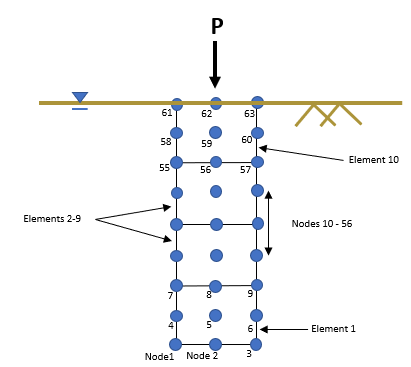

# Material

This example consists of a single homogeneous soil layer in which an axial load is applied to the soil surface. The soil layer used is assumed to be a cohesive material.

# Loading and Analysis

The loading is vertically applied to the centre of the model in the downward direction. Using the opensees framework, the vertical effective stress, excess pore pressures and settlements are analysised for 200 seconds with a time step of 0.25 seconds (a total of 800 iterations).

# Outcomes

The parameters that you are able to change include:
- Drainage
- Vertical permeability (m/s)
- Cohesion (kPa)
- Applied load (P)

Drainage 1 represents a single porous boundary (d = H) also known as One Way Drainage. 
Drainage 2 represents the soil layer being encased within two pourous boundaries (d = H/2). Drainage 2 can be called Two Way Drainage.


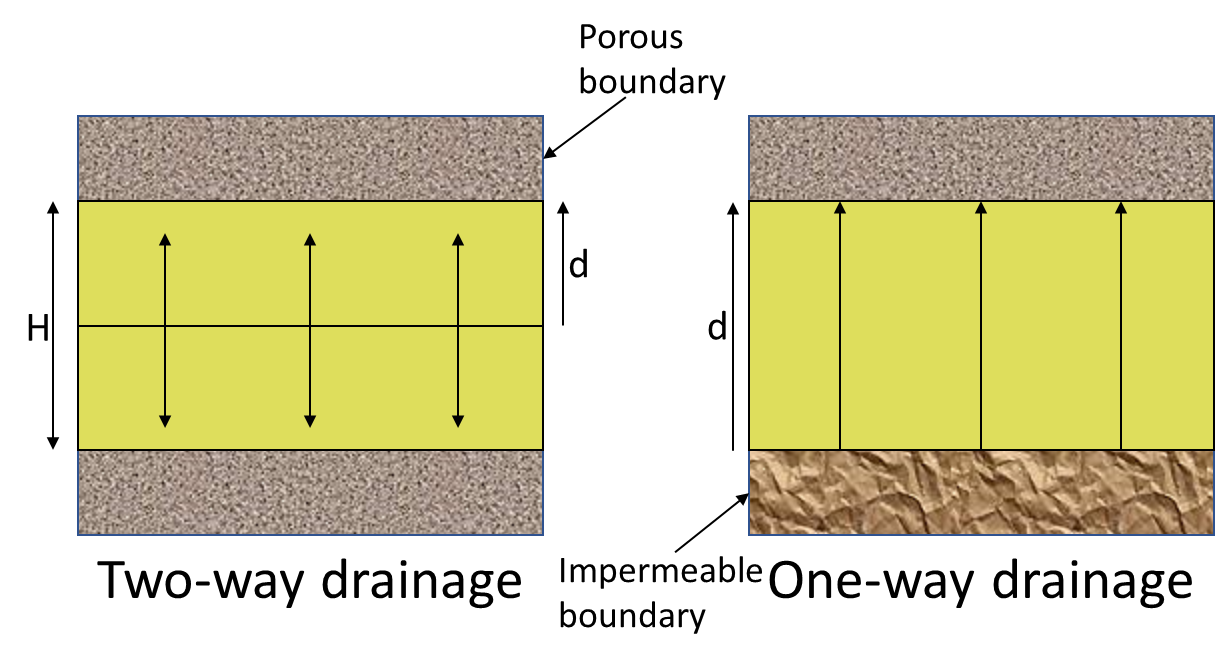

In [1]:
import openseespy.opensees as op
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as wid

In [2]:
def one_Dimentional_Consolidation(load = 600, drainage = 1, mPermV = 5e-5, cohesion = 45):
    op.wipe()

    # specify desired drainage type; 1 --> single drainage, 2 --> double drainage
    #drainage = 1

    # 1. Define Mesh geometry 

    #Number of elements in horizontal direction
    numEleX = 1

    #Size of elements in horizontal direction (m)
    sizeEleX = 1.0

    #Number of nodes in horizontal direction
    numNodeX = 2*numEleX + 1

    #Number of elements in vertical direction
    numEleY = 10

    #Size of elements in vertical direction (m)
    sizeEleY = 1.0

    #Number of nodes in vertical direction
    numNodeY = 2 * numEleY + 1

    #Total number of nodes
    totalNumNode = 3 * numNodeY

    #Total number of elements
    totalNumEle = numEleX * numEleY

    #2. Define corner nodes

    op.model('basic', '-ndm', 2, '-ndf', 3)


    for i in range(1, numNodeX+1, 2):
        for j in range(1, numNodeY+1, 2):      
            xCoord = (i-1)*sizeEleX/2
            yCoord = (j-1)*sizeEleY/2
            nodeNum = i+(j-1)*numNodeX
            op.node(nodeNum, xCoord, yCoord)
            #print('Node {},{},{}'.format(nodeNum,xCoord,yCoord))
    #print('Finished creating corner soil nodes ...')


    # 3. Define boundary conditions for corner nodes
    if drainage == 1:
        op.fix(1,1,1,0)
        op.fix(3,1,1,0)
    else:
        op.fix(1,1,1,1)
        op.fix(3,1,1,1)

    #Fix horizontal displacement and porepressure DOF for nodes at the top
    op.fix(totalNumNode-2, 1, 0, 1)
    op.fix(totalNumNode, 1, 0, 1)

    # Fix horizontal displacement for all remaining nodes

    #Check sith chris that starting node at 7 is all good, as node 1 was already fixed at 1 and caused error
    for i in range(7, 3*numNodeY-5, 6):
        op.fix(i, 1, 0, 0)
        op.fix(i+2, 1, 0, 0)

    #print("Finished creating boundary conditions for corner nodes...")

    # 4. Define Interior Nodes

    op.model('basic', '-ndm', 2, '-ndf', 2)

    #Central column of nodes

    xCoord = sizeEleX/2
    for j in range(1, numEleY+1):
        yCoord = j-0.5
        nodeNumL = 6*j-2
        nodeNumR = nodeNumL + 2 
        op.node(nodeNumL, 0.0, yCoord)
        op.node(nodeNumR, sizeEleX, yCoord)
        #print('Node, {}, {}, {}'.format(nodeNumL, 0.0, yCoord))
        #print('Node, {}, {}, {}'.format(nodeNumR, sizeEleX, yCoord))

    for j in range(1, numNodeY+1):
        #nodeNumC = 3*j - 1
        yCoord = (j-1)*sizeEleX/2
        nodeNum = 3*j - 1
        op.node(nodeNum, 0.5, yCoord)
        #print('Node, {}, {}, {}'.format(nodeNum, 0.5, yCoord))

    #print('Finished creating all soil Nodes...')

    #5. Define Boundary conditions for interior nodes

    op.fix(2,1,1)

    for i in range(1, numEleY+1):
        nodeNumL = 6*i-2
        nodeNumR = nodeNumL +2
        op.fix(nodeNumL, 1, 0)
        op.fix(nodeNumR, 1, 0)
        #print('fix {}, 1, 0'.format(nodeNumL))
        #print('fix {}, 1, 0'.format(nodeNumR))

    #Check the below commands, Changed the variable to fit (+1 on each due to python finishing 1 before end)
    op.equalDOF(totalNumNode-1, totalNumNode - 2, 1, 2)
    op.equalDOF(totalNumNode-1, totalNumNode, 1, 2)

    #print("Finished creating all boundary conditions and equal DOF...")

    # 6. Define Material Properties of soil

    #Saturated mass density (Mg/m3)
    satDensity = 2.3

    #Fluid Density (Mg/m3)
    h2ODensity = 1

    #Shear modulus (kPa)
    shear = 2.5e4

    #Bulk modulus (kPa)
    bulk = 6.2e5

    #undrained bulk modulus
    uBulk = 2.2e5

    #Vertical permeability, input value in m/s, units are modified to suit constitutive model
    #mPermV = 5e-5
    vPerm = mPermV / 9.81 / h2ODensity

    # Horizontal permeability, input value m/s, units are modified to suit constitutive model
    mPermH = 5e-5
    hPerm = mPermH / 9.81 / h2ODensity

    #Cohesion (kPa)
    #cohesion = 45.0

    #Friction angle (Degrees)
    phi = 0.0

    #Peak shear strain 
    gammaPeak = 0.1

    #Reference pressure (kPa)
    refPress = 80.0

    #Pressure dependency coefficient
    pressCoeff = 0.0

    #number of yield surfaces
    numSurf = 22

    # 7. Define soil materials

    matTag = 1
    op.nDMaterial('PressureIndependMultiYield', matTag, 2, satDensity, shear, bulk, cohesion, gammaPeak, phi, refPress, pressCoeff, numSurf)
    #print('Finished creating all soil materials...')

    # 8. Define Soil Elements
    thick = 1
    wgtX = 0.0
    wgtY = -9.81

    for j in range(1, numEleY+1):
        nI = 6 * j - 5
        nJ = nI + 2
        nK = nI + 8
        nL = nI + 6
        nM = nI + 1
        nN = nI + 5
        nP = nI + 7
        nQ = nI + 3
        nR = nI + 4
        op.element('9_4_QuadUP', j, nI, nJ, nK, nL, nM, nN, nP, nQ, nR, thick, matTag, bulk, h2ODensity, hPerm, vPerm, wgtX, wgtY)
    op.updateMaterialStage('-material', matTag, '-stage', 0)

    # 9. Apply Gravity Loading
    #Newmark parameters
    gamma = 0.5
    beta = 0.25

    #Analysis objects
    op.constraints('Transformation')
    op.test('NormDispIncr', 1e-2, 30, 0)
    op.algorithm('Newton')
    op.numberer('RCM')
    op.system('ProfileSPD')
    op.integrator('Newmark', gamma, beta)
    op.analysis('Transient')
    op.analyze(10, 5)
    #print('Finished with elastic gravity analysis')

    # 10. Update soil material stage
    op.updateMaterialStage('-material', matTag, '-stage', 1)
    op.analyze(45, 5.0e2)
    #print('Finished with plastic gravity analysis ...')

    # 11. Consolidation analysis
    op.wipeAnalysis()
    op.setTime(0.0) 
    #op.wipeAnalysis()

    #overburden = -1000
    loadVals = [0.0, -load]
    op.timeSeries('Constant', 1, '-factor', 1.0)
    op.pattern('Plain', 1, 1)
    op.load(totalNumNode - 1, *loadVals)

    # Analysis objects
    op.constraints('Penalty', 1.0e16, 1.0e16)
    op.test('NormDispIncr', 1e-2, 30, 0)
    op.algorithm('Newton')
    op.numberer('RCM')
    op.system('ProfileSPD')
    op.integrator('Newmark', gamma, beta)
    op.rayleigh(0.5, 0.2, 0.0, 0.0)
    op.analysis('Transient')

    #Pore Pressure analysis
    totPorePressure = []
    surdisp = []
    stress = []
    response = ['material', 9, 'stress']

    for i in range(0 , 800):
        op.analyze(1, 0.25)
        for j in range(1, totalNumNode+1):
            totPorePressure.append(op.nodeResponse(j, 3, 2))
        for k in range(totalNumNode-2, totalNumNode+1):
            surdisp.append(op.nodeResponse(k, 2, 1))
        for y in range(1, totalNumEle+1):
            stress.append(op.eleResponse(y, *response))

    count = 0
    newArray = []
    vStress = []
    for i in stress:
        newArray.append(i)
        count += 1
        if count == 10:
            count = 0
            vStress.append(newArray)
            newArray = []
    vStress = np.array(vStress)   

    count = 0
    newArray = []
    newArray1 = []
    totPorePressureArray = []

    for i in totPorePressure:
        if int(i) < 0.1:
            i = 0.0
        newArray.append(i)
        count += 1
        if count == totalNumNode:
            count = 0
            count1 = 0
            for p in newArray:
                if count1 == 0:
                    newArray1.append(p)
                count1 += 1
                if count1 == 6:
                    count1 = 0
            totPorePressureArray.append(newArray1)
            newArray = [] 
            newArray1 = []
    totPorePressureArray = np.array(totPorePressureArray)

    #Settlement analysis
    count = 0
    newArray = [] 
    surDispArray = []

    for i in surdisp:
        newArray.append(i)
        count += 1
        if count == 3:
            count = 0
            surDispArray.append(newArray)
            newArray = []

    surDispArray = np.array(surDispArray)

    time = np.linspace(0,200,800)

    #Creating the subplots
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (20,5), constrained_layout = True)
    axs = axs.flatten()
    
    #Pore Pressure
    for i in range(2,len(totPorePressureArray)):
        x_ax = totPorePressureArray[i,:]
        y_ax = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
        if i == 2:
            axs[0].plot(x_ax, y_ax, '.b-')
        elif(i>2 and i<12):
            axs[0].plot(x_ax, y_ax, '.g-')
        else:
            axs[0].plot(x_ax, y_ax, '.y-')
    
    axs[0].set_xlabel('Excess pore pressure (kPa)', fontsize = 18)
    axs[0].set_ylabel('Depth (m)', fontsize = 18)
    axs[0].set_xlim(0,650)
    axs[0].set_ylim(0,10)
    axs[0].invert_yaxis()

    #Surface displacement
    for i in range(0, len(surDispArray)):
        t_ax = time
        settlem = surDispArray[:,1]*1000 
        axs[1].plot(t_ax, settlem,'.b-')  
    axs[1].set_xlabel('Time (s)', fontsize = 18)
    axs[1].set_ylabel('Settlement at surface (mm)', fontsize = 18)
    axs[1].set_xlim(-0.1,200)
    axs[1].set_ylim(-18, -0)
    max_set = surDispArray[-1,1] * 1000

    # Vertical effective stress
    for i in range(2, 799):
        y_ax = [9.5, 8.5, 7.5, 6.5, 5.5, 4.5, 3.5, 2.5, 1.5, 0.5]
        vert_Stress = -vStress[i][:,1]
        if i == 2:
            axs[2].plot(vert_Stress, y_ax, '.b-')
        elif(i>2 and i<12):
            axs[2].plot(vert_Stress, y_ax, '.g-')
        else:
            axs[2].plot(vert_Stress, y_ax, '.y-')
    plt.yticks(np.arange(0,11,1))    
    axs[2].set_xlabel('Vertical effective stress (kPa)', fontsize = 18)
    axs[2].set_ylabel('Depth (m)', fontsize = 18)
    axs[2].set
    axs[2].set_xlim(150, 1250)
    axs[2].set_ylim(0,10)
    axs[2].invert_yaxis()
    plt.rcParams.update({'font.size': 14})

    print('The maximum soil settlement is {:.1f} mm'.format(-max_set))

In [3]:
wid.interact(one_Dimentional_Consolidation, load=wid.IntSlider(max=1000, min=400,value = 1000, description = 'P (kN)', step = 200, continuous_update=False),drainage = [1.0,2.0], mPermV = wid.Dropdown(options = [5e-5,4e-5, 3e-5, 2e-5, 1e-5], value = 5e-5, description = "Permeability (k)"),cohesion = [90, 75, 60, 45, 30, 15])

interactive(children=(IntSlider(value=1000, continuous_update=False, description='P (kN)', max=1000, min=400, …

<function __main__.one_Dimentional_Consolidation(load=600, drainage=1, mPermV=5e-05, cohesion=45)>

# Result Interpretation

### Colours

The initial iteration (t = 0.25s) is shown as the blue line for both Excess pore pressure and Vertical effective stress plots. Iterations two to ten (t = 0.5s -> t = 2.5s) is presented in green. The rest of the analysis is presented in yellow.